<a href="https://colab.research.google.com/github/ahmadelsallab/MultiCheXNet/blob/Detection/Baseline_Detection_(100%25TF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This Code is Detection for only positive cases in pneumonia**


# **Import**

In [ ]:
# !pip3 install --upgrade --force-reinstall kaggle

In [1]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

In [ ]:
!unzip rsna-pneumonia-detection-challenge.zip

In [ ]:
!pip install pydicom

In [ ]:
!pip install pydicom
import pydicom
import os
import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
###############

import xml.etree.ElementTree as ET
import imgaug as ia
from imgaug import augmenters as iaa
import pandas as pd
from tqdm import tqdm
from skimage.transform import resize
import skimage
from sklearn.utils import shuffle
from skimage import exposure
import random
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
%matplotlib inline
ia.seed(1)

In [3]:
import tensorflow as tf
print('Tensorflow version : {}'.format(tf.__version__))
print('GPU : {}'.format(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *

Tensorflow version : 2.2.0
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **Initialize Parameters**

In [4]:
# Parameters

LABELS           = ['pneumonia']
IMAGE_H, IMAGE_W = 256, 256
GRID_H,  GRID_W  = 8, 8 # GRID size = IMAGE size / 32
BOX              = 5
CLASS            = len(LABELS)
SCORE_THRESHOLD  = 0.5
IOU_THRESHOLD    = 0.45
ANCHORS          = np.array([1.08, 1.19, 3.42, 4.41, 6.63, 11.38, 9.42, 5.11, 16.62, 10.52]).reshape(5, 2)

TRAIN_BATCH_SIZE = 10
VAL_BATCH_SIZE   = 10
EPOCHS           = 10

LAMBDA_NOOBJECT  = 1
LAMBDA_OBJECT    = 5
LAMBDA_CLASS     = 1
LAMBDA_COORD     = 1

max_annot        = 0

# **Process**

## **GroundTruth process**

In [5]:
def bbToYoloFormat(bb):
    """
    converts (left, top, right, bottom) to
    (center_x, center_y, center_w, center_h)
    """
    x1, y1, x2, y2 = np.split(bb, 4, axis=1) 
    w = x2 - x1
    h = y2 - y1
    c_x = x1 + w / 2
    c_y = y1 + h / 2
    
    return np.concatenate([c_x, c_y, w, h], axis=-1)
def findBestPrior(bb, priors):
    """
    Given bounding boxes in yolo format and anchor priors
    compute the best anchor prior for each bounding box
    """
    w1, h1 = bb[:, 2], bb[:, 3]
    w2, h2 = priors[:, 0], priors[:, 1]
    
    # overlap, assumes top left corner of both at (0, 0)
    horizontal_overlap = np.minimum(w1[:, None], w2)
    vertical_overlap = np.minimum(h1[:, None], h2)
    
    intersection = horizontal_overlap * vertical_overlap
    union = (w1 * h1)[:, None] + (w2 * h2) - intersection
    iou = intersection / union
    return np.argmax(iou, axis=1)
def processGroundTruth(bb, labels, priors, network_output_shape):
    """
    Given bounding boxes in normal x1,y1,x2,y2 format, the relevant labels in one-hot form,
    the anchor priors and the yolo model's output shape
    build the y_true vector to be used in yolov2 loss calculation
    """
    bb = bbToYoloFormat(bb) / 32
    best_anchor_indices = findBestPrior(bb, priors)
    
    responsible_grid_coords = np.floor(bb).astype(np.uint32)[:, :2]
    
    values = np.concatenate((
        bb, np.ones((len(bb), 1)), labels
    ), axis=1)
    
    x, y = np.split(responsible_grid_coords, 2, axis=1)
    y = y.ravel()
    x = x.ravel()
    
    y_true = np.zeros(network_output_shape)    
    y_true[y, x, best_anchor_indices] = values
    
    return y_true

## **Data Generator with augumentation**

In [6]:
class Data_Generator(tf.keras.utils.Sequence):
    'Generates data from a Dataframe'
    def __init__(self,csv_path,patientId , img_path ,batch_size=16, dim=(256,256), n_channels=3,
                 n_classes=1, shuffle=True,transform=None , only_positive=True, preprocess = None,aug=False):
        
        self.df = pd.read_csv(csv_path)
        if only_positive:
            self.df= self.df[self.df["Target"]==1]
            
        self.img_path = img_path
        self.patient_ids = patientId
        
        self.batch_size = batch_size
        self.nb_iteration = int(len(self.patient_ids)/self.batch_size)
        self.dim = dim
        self.n_channels= n_channels
        
        self.preprocess =preprocess
        self.aug=aug
        self.transform=transform
        self.TINY_YOLOV2_ANCHOR_PRIORS = np.array([1.08, 1.19, 3.42, 4.41, 6.63, 11.38, 9.42, 5.11, 16.62, 10.52]).reshape(5, 2)
        self.network_output_shape = (8,8,5,6)
    
    
                    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.nb_iteration

    def __getitem__(self, index):
        'Generate one batch of data'
        
        indicies = range(index*self.batch_size, min((index*self.batch_size)+self.batch_size ,len(self.patient_ids) ))
            
        patientIds = self.patient_ids[indicies]
        X = np.zeros((self.batch_size, self.dim[0], self.dim[1],self.n_channels))
        # y_boxes = []
        y = np.zeros((self.batch_size,self.network_output_shape[0],self.network_output_shape[1],self.network_output_shape[2],self.network_output_shape[3]))
        output_labels = []
        
        
        for index , patientId in enumerate(patientIds):
            filtered_df = self.df[self.df["patientId"] == patientId]
            img_path = os.path.join(self.img_path,patientId+".dcm" )
            img = self.load_img(img_path)
            
            
            y_boxes = []
            labels = []
            y_ = []
            for i, row in filtered_df.iterrows():
                xmin = int(row['x'])
                ymin = int(row['y'])
                xmax = int(xmin + row['width'])
                ymax = int(ymin + row['height'])
                
                xmin = int((xmin/1024)*self.dim[0])
                xmax = int((xmax/1024)*self.dim[0])
                
                ymin = int((ymin/1024)*self.dim[1])
                ymax = int((ymax/1024)*self.dim[1])
                y_boxes.append([xmin,ymin,xmax,ymax])
                
                labels.append([1])
                
            
            #run preprocess_bboxes
            if self.aug != False:
              # https://github.com/aleju/imgaug
              # https://imgaug.readthedocs.io/en/latest/source/examples_bounding_boxes.html
              
              seq = iaa.Sequential([iaa.Affine(translate_percent={"x": (0.01,0.1)},scale=(0.5,1)),
                                    # iaa.Affine(rotate=(-25, 25)),
                                    iaa.Crop(percent=(0, 0.2)),
                                    iaa.Fliplr(0.2),
                                    iaa.Flipud(0.2)])
                                    #  ,random_order=True)
              
              ia_bbs = [ia.BoundingBox(x1=b[0], y1=b[1],x2=b[2], y2=b[3]) for b in y_boxes]
              ia_boxes=ia.BoundingBoxesOnImage(ia_bbs, shape=(256,256))
              image_aug, bbs_aug = seq(image=img, bounding_boxes=ia_boxes)
              for i in range(len(bbs_aug.bounding_boxes)):
                bb = bbs_aug.bounding_boxes[i]
                annot=[int(bb.x1),int(bb.y1),int(bb.x2),int(bb.y2)]
                y_.append(np.clip(annot, 0, self.dim[0] - 1))
            
              X[index]= image_aug
              y[index] = processGroundTruth(np.array(y_),np.array(labels), self.TINY_YOLOV2_ANCHOR_PRIORS , self.network_output_shape)
            else:
              X[index]= img
              y[index] = processGroundTruth(np.array(y_boxes),np.array(labels), self.TINY_YOLOV2_ANCHOR_PRIORS , self.network_output_shape)
              
        return X, y
    
    
    
    def load_img(self,img_path):
        dcm_data = pydicom.read_file(img_path)
        a = dcm_data.pixel_array

        a=cv2.resize(a,(self.dim))
        if self.n_channels == 3:
            a = skimage.color.gray2rgb(a)
        
        if self.preprocess != None:
          tf.keras.preprocessing.image.ImageDataGenerator(a)
        
        if self.transform != None:
            params = transform.get_random_transform(a.shape)
            img = transform.apply_transform(a,params)
            # a= self.preprocess(a)
            # tf.keras.applications.densenet.preprocess_input(a)
        
        a = exposure.equalize_adapthist(a)
        # a=(a*255).astype('uint8')
        return a

## **Load Data**

In [7]:

csv_path= "/content/stage_2_train_labels.csv"
images_path = "/content/stage_2_train_images/"

df = pd.read_csv(csv_path)
df= df[df["Target"]==1]

random.seed(42)
patient_ids = df["patientId"].unique()
random.shuffle(patient_ids)

validation_split = 0.2
patient_ids_train = patient_ids[int(len(patient_ids)*(validation_split)):]
patient_ids_validation = patient_ids[:int(len(patient_ids)*(validation_split))]

In [27]:
train_generator = Data_Generator(csv_path,patient_ids_train, images_path , batch_size=16 , aug=True)
validation_generator = Data_Generator(csv_path,patient_ids_validation, images_path, batch_size=16 )

The number of batches for this data =  300


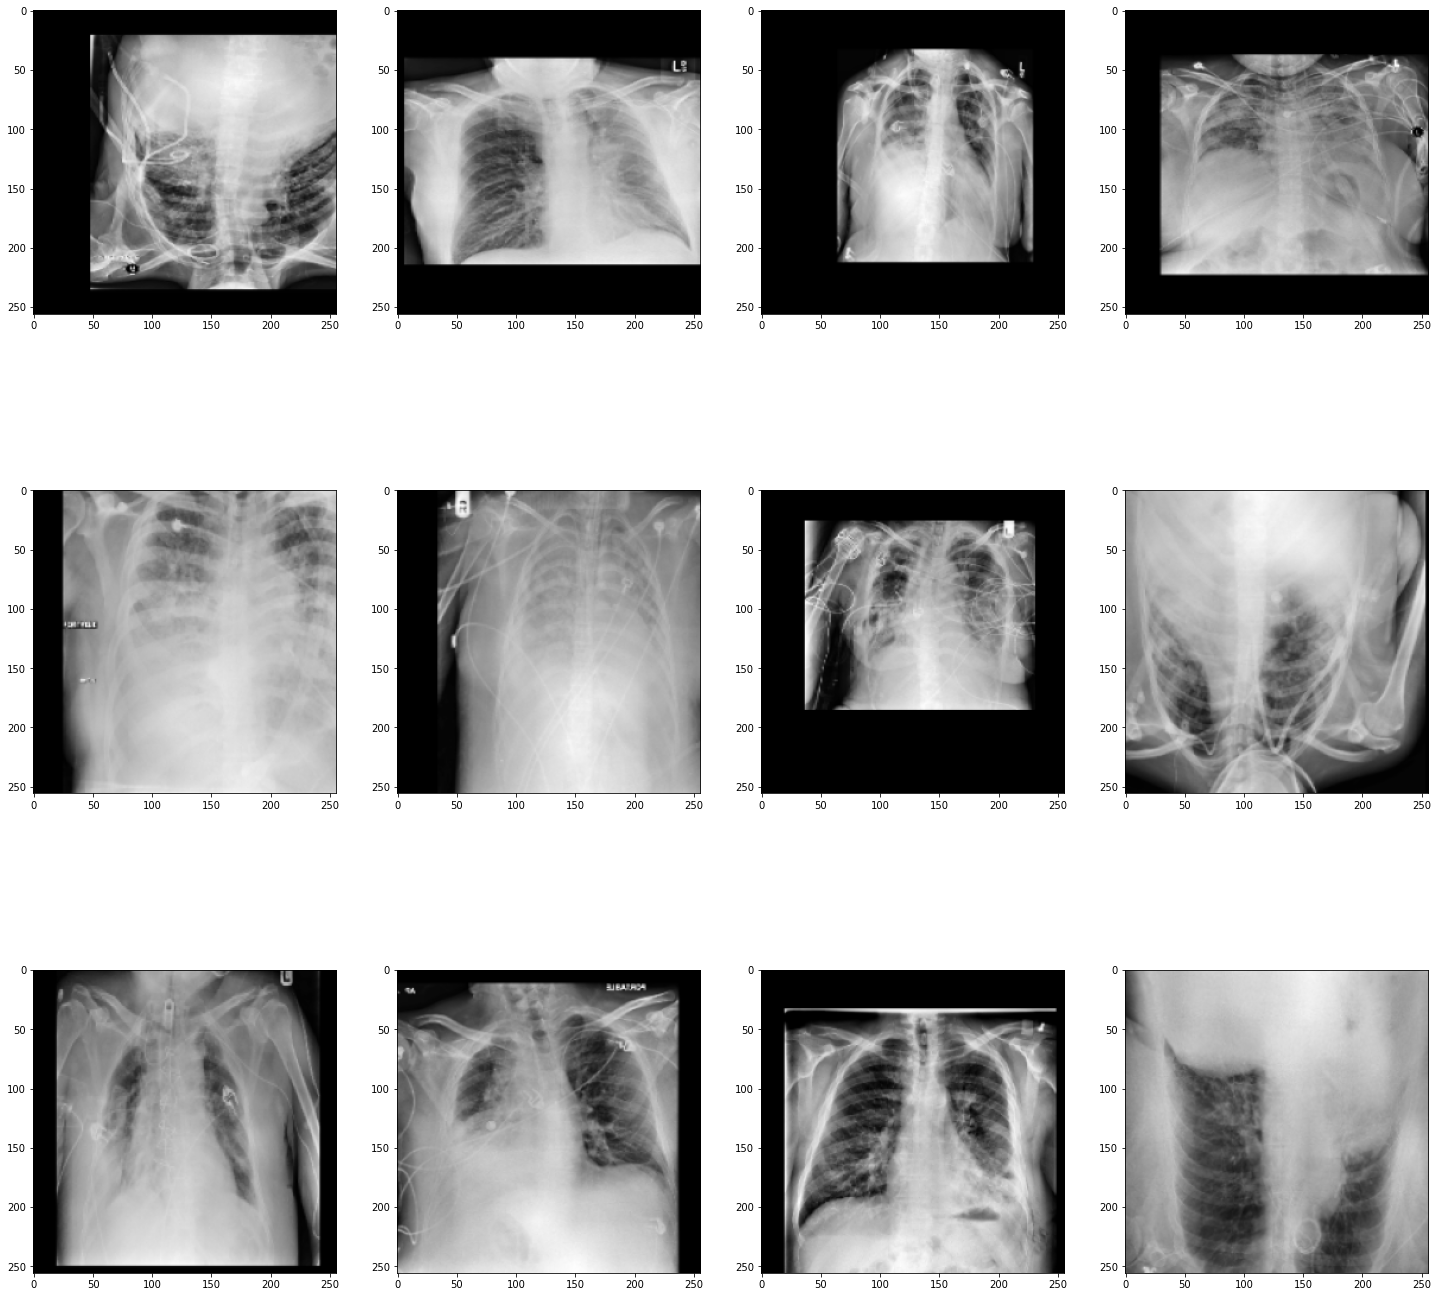

In [28]:
def show_batch(generator, batch_number= 0):
  '''
  Helper function to show generated batch from `DataGenerator` class
  You expected to see some images with corresponding ID and class label 
  args:-
    generator: Data generator contains the labels and imgs.
    batch_number: Number that in range of the number of batches of the data generator    
  '''
  print("The number of batches for this data = ", len(generator))
  
#batch
  imgs,boxes = generator.__getitem__(batch_number)
  
  fig=plt.figure(figsize=(25, 25))
  columns = 4
  rows = 3
  for i in range(1, (columns*rows)+1):
    img = imgs[i]
    # img = np.squeeze(img, axis = 2)
    fig.add_subplot(rows, columns, i)
    #plt.title(str(ID[i])+'  '+str(labels[i]), fontsize = 10)
    plt.imshow(img, cmap='gray')
  plt.show()

show_batch(train_generator,1)

## **Loss Function**

In [10]:
def loss( y_true, y_pred):
  TINY_YOLOV2_ANCHOR_PRIORS = np.array([1.08, 1.19, 3.42, 4.41, 6.63, 11.38, 9.42, 5.11, 16.62, 10.52]).reshape(5, 2)
  TINY_YOLOV2_ANCHOR_PRIORS = tf.convert_to_tensor(TINY_YOLOV2_ANCHOR_PRIORS, dtype= tf.float32)
  
  n_cells = y_pred.get_shape().as_list()[1]
  y_true = tf.reshape(y_true, tf.shape(y_pred), name='y_true')
  y_pred = tf.identity(y_pred, name='y_pred')

  #### PROCESS PREDICTIONS ####
  # get x-y coords (for now they are with respect to cell)
  predicted_xy = tf.nn.sigmoid(y_pred[..., :2])

  # convert xy coords to be with respect to image
  cell_inds = tf.range(n_cells, dtype=tf.float32)
  predicted_xy = tf.stack((
      predicted_xy[..., 0] + tf.reshape(cell_inds, [1, -1, 1]),
      predicted_xy[..., 1] + tf.reshape(cell_inds, [-1, 1, 1])
  ), axis=-1)

  # compute bb width and height
  predicted_wh = TINY_YOLOV2_ANCHOR_PRIORS * tf.exp(y_pred[..., 2:4])

  # compute predicted bb center and width
  predicted_min = predicted_xy - predicted_wh / 2
  predicted_max = predicted_xy + predicted_wh / 2

  predicted_objectedness = tf.nn.sigmoid(y_pred[..., 4])
  predicted_logits = tf.nn.softmax(y_pred[..., 5:])

  #### PROCESS TRUE ####
  true_xy = y_true[..., :2]
  true_wh = y_true[..., 2:4]
  true_logits = y_true[..., 5:]

  true_min = true_xy - true_wh / 2
  true_max = true_xy + true_wh / 2

  #### compute iou between ground truth and predicted (used for objectedness) ####
  intersect_mins = tf.maximum(predicted_min, true_min)
  intersect_maxes = tf.minimum(predicted_max, true_max)
  intersect_wh = tf.maximum(intersect_maxes - intersect_mins, 0.)
  intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

  true_areas = true_wh[..., 0] * true_wh[..., 1]
  pred_areas = predicted_wh[..., 0] * predicted_wh[..., 1]

  union_areas = pred_areas + true_areas - intersect_areas
  iou_scores = intersect_areas / union_areas

  #### Compute loss terms ####
  responsibility_selector = y_true[..., 4]

  xy_diff = tf.square(true_xy - predicted_xy) * responsibility_selector[..., None]
  xy_loss = tf.reduce_sum(xy_diff, axis=[1, 2, 3, 4])

  wh_diff = tf.square(tf.sqrt(true_wh) - tf.sqrt(predicted_wh)) * responsibility_selector[..., None]
  wh_loss = tf.reduce_sum(wh_diff, axis=[1, 2, 3, 4])

  obj_diff = tf.square(iou_scores - predicted_objectedness) * responsibility_selector
  obj_loss = tf.reduce_sum(obj_diff, axis=[1, 2, 3])

  best_iou = tf.reduce_max(iou_scores, axis=-1)
  no_obj_diff = tf.square(0 - predicted_objectedness) * tf.cast(best_iou < 0.6, dtype=tf.float32)[..., None] * (
              1 - responsibility_selector)
  no_obj_loss = tf.reduce_sum(no_obj_diff, axis=[1, 2, 3])

  clf_diff = tf.square(true_logits - predicted_logits) * responsibility_selector[..., None]
  clf_loss = tf.reduce_sum(clf_diff, axis=[1, 2, 3, 4])

  object_coord_scale = 5
  object_conf_scale = 1
  noobject_conf_scale = 1
  object_class_scale = 1

  loss = object_coord_scale * (xy_loss + wh_loss) + \
          object_conf_scale * obj_loss + noobject_conf_scale * no_obj_loss + \
          object_class_scale * clf_loss
  
  
  return loss

## **Training**

In [10]:
class CustomCallBacks():
    """
    How to Use:
    monitor = CustomeCallBacksObject.calls('DetectionModel.h5',
                  checkpointMonitor = 'val_loss',
                  checkpointMode = 'auto',
                  earlyStopMonitor = 'val_loss',
                  earlyStopPatience = 10,
                  earlyStopMode = 'auto',
                  useReduceOnPlateau = False,
                  useLearningRateScheduler = True)
                  
    model.fit(..., callbacks=monitor)
    """
    
    def calls(self,
              model_name, 
              checkpointMonitor = 'val_loss',
              checkpointMode = 'auto',
              earlyStopMonitor = 'val_loss',
              earlyStopPatience = 10,
              earlyStopMode = 'auto',
              useReduceOnPlateau = False,
              useLearningRateScheduler = False
              ):
        checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                                    monitor= checkpointMonitor,
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode=checkpointMode,
                                    period=1)
        
        early = tf.keras.callbacks.EarlyStopping(monitor=earlyStopMonitor,
                                min_delta=0,
                                patience=earlyStopPatience,
                                verbose=1,
                                mode=earlyStopMode)
        
        class myCallBack(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs={}):
                if (logs.get('val_accuracy') > 0.998):
                    print ('\nReached 0.998 Validation accuracy!')
                    self.model.stop_training = True

        my_call = myCallBack()

        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5,
                                    verbose=1, mode='min', min_delta=0,
                                    cooldown=0, min_lr=0)
        
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 10))
        
        monitor = [checkpoint, early]
        if useReduceOnPlateau:
            monitor.append(reduce_lr)
        if useLearningRateScheduler:
            monitor.append(lr_schedule)
        return monitor

In [11]:
c = CustomCallBacks()

In [22]:
monitor = c.calls('DetectionModel_v4.h5',
                  checkpointMonitor = 'val_loss',
                  checkpointMode = 'auto',
                  earlyStopMonitor = 'val_loss',
                  earlyStopPatience = 10,
                  earlyStopMode = 'auto',
                  useReduceOnPlateau = False,
                  useLearningRateScheduler = [False])

In [ ]:
# !gdown --id 1JsLdSbICpbZLJFYn-kWihTKAczj3EeaW #load pretrained model with mAP=0.35
!gdown --id 1tO5di1l7inCG07V6clwOk8f2HpTbjZyv  #load pretrained model with mAP=0.4

In [29]:
# tf.keras.backend.clear_session()

In [34]:
model = tf.keras.models.load_model("/content/DetectionModel.h5", custom_objects={'loss':loss})
# model.summary()

In [31]:
from tensorflow.keras.optimizers import Adam
model.compile(loss= loss, optimizer= Adam(0.001))

In [ ]:
monitor= tf.keras.callbacks.ModelCheckpoint('DetectionModel_v4.h5',
                                    monitor=  'val_loss',
                                    verbose=1,
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='min',
                                    period=1)

In [ ]:
num_epochs = 50

history= model.fit(train_generator, validation_data= validation_generator ,epochs=num_epochs ,
                   callbacks=monitor)

In [25]:
def plot_charts(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))


  plt.plot(epochs, loss, 'r', label = 'Training Loss')
  plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
  plt.title('Training and validation Loss')
  plt.legend()
  plt.figure()

  plt.show()

In [ ]:
plot_charts(history)

## **Show Results**

In [36]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_out = np.exp(x - np.max(x, axis=-1)[..., None])
    return exp_out / np.sum(exp_out, axis=-1)[..., None]

# https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression(boxes, labels, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        i = idxs[-1]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:-1]])
        yy1 = np.maximum(y1[i], y1[idxs[:-1]])
        xx2 = np.minimum(x2[i], x2[idxs[:-1]])
        yy2 = np.minimum(y2[i], y2[idxs[:-1]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:-1]]
 
        # delete all indexes from the index list that have
        idxs = (idxs[:-1])[overlap < overlapThresh]
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick], labels[pick]
def getBoundingBoxesFromNetOutput(clf, anchors, confidence_threshold, cell_size):
    pw, ph = anchors[:, 0], anchors[:, 1]
    cell_inds = np.arange(clf.shape[1])

    tx = clf[..., 0]
    ty = clf[..., 1]
    tw = clf[..., 2]
    th = clf[..., 3]
    to = clf[..., 4]

    sftmx = softmax(clf[..., 5:])
    predicted_labels = np.argmax(sftmx, axis=-1)
    class_confidences = np.max(sftmx, axis=-1)

    bx = logistic(tx) + cell_inds[None, :, None]
    by = logistic(ty) + cell_inds[:, None, None]
    bw = pw * np.exp(tw) / 2
    bh = ph * np.exp(th) / 2
    object_confidences = logistic(to)

    left = bx - bw
    right = bx + bw
    top = by - bh
    bottom = by + bh

    boxes = np.stack((
        left, top, right, bottom
    ), axis=-1) * cell_size
    
    final_confidence = class_confidences * object_confidences
    boxes = boxes[final_confidence > confidence_threshold].reshape(-1, 4).astype(np.int32)
    labels = predicted_labels[final_confidence > confidence_threshold]
    confidence = final_confidence[final_confidence > confidence_threshold]
    confidence = confidence[confidence.argsort()][::-1]

    return boxes, labels, confidence

def yoloPostProcess(yolo_output, priors, maxsuppression=True, maxsuppressionthresh=0.5, classthresh=0.6, cell_size=32):
    allboxes = []
    for o in yolo_output:
        boxes, labels, final_confidence = getBoundingBoxesFromNetOutput(o, priors, confidence_threshold=classthresh, cell_size=cell_size)
        if maxsuppression:
            if len(boxes) > 0:
                boxes, labels = non_max_suppression(boxes, labels, maxsuppressionthresh)
                # print((boxes.shape, labels.shape, final_confidence[:len(boxes)].shape))
                allboxes.append((boxes, labels, final_confidence[:len(boxes)]))
            else:
                allboxes.append(([], [], []))

    return allboxes

In [37]:
def annotate_image(image, boxes, labels, class_names, Itype, c):
    image = image.copy()

    for (left, top, right, bottom), label in zip(boxes, labels):
        image = cv2.rectangle(image, (left, top), 
                (right, bottom), color=c, thickness=2)
        image = cv2.putText(
            image,  Itype, (left, top-10), 
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, c
        )

    return image

In [85]:
def show_result(csv_path,pid,images_path , nms_thrishold,class_thresh):

  '''
  csv_path: path of annot of data
  pid: IDs
  images_path: directory of images folder
  '''
  df = pd.read_csv(csv_path)
  df= df[df["Target"]==1]
  columns = 4
  rows = 4
  fig=plt.figure(figsize=(25, 25))
  l = [random.randint(0,len(pid)) for i in range(columns*rows)]
  # n = random.randint(0,len(pid))
  
  for j in range(1,(columns*rows)+1):
    n=l[j-1]
    id = pid[n]
    
    file = df[df.patientId == id]
    img = resize(pydicom.read_file(images_path + id + '.dcm').pixel_array, 
                                        (256, 256),
                                        anti_aliasing=True)
    img = skimage.color.gray2rgb(img)

    t_boxes = []
    t_labels = []
    for i, row in file.iterrows():
        xmin = int(row['x'])
        ymin = int(row['y'])
        xmax = int(xmin + row['width'])
        ymax = int(ymin + row['height'])
        
        xmin = int((xmin/1024)*256)
        xmax = int((xmax/1024)*256)

        ymin = int((ymin/1024)*256)
        ymax = int((ymax/1024)*256)
        t_boxes.append([xmin,ymin,xmax,ymax])
        t_labels.append(1)
    img1 = annotate_image(img, t_boxes, t_labels, LABELS,'GT', (0,255,0))

    output = model2.predict(img[None])
    p = np.array([1.08, 1.19, 3.42, 4.41, 6.63, 11.38, 9.42, 5.11, 16.62, 10.52]).reshape(5, 2)
    output = yoloPostProcess(output, p,maxsuppressionthresh=nms_thrishold,classthresh=class_thresh)
    if len(output) > 0:
        boxes, labels, scores = output[0]
        ####
        img2 = annotate_image(img1, boxes, labels, LABELS, 'P', (255,0,0))
    else:
        img2 = img1
    fig.add_subplot(rows, columns, j)
    plt.imshow(img2.astype(np.float32))

    plt.axis('off')  
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255

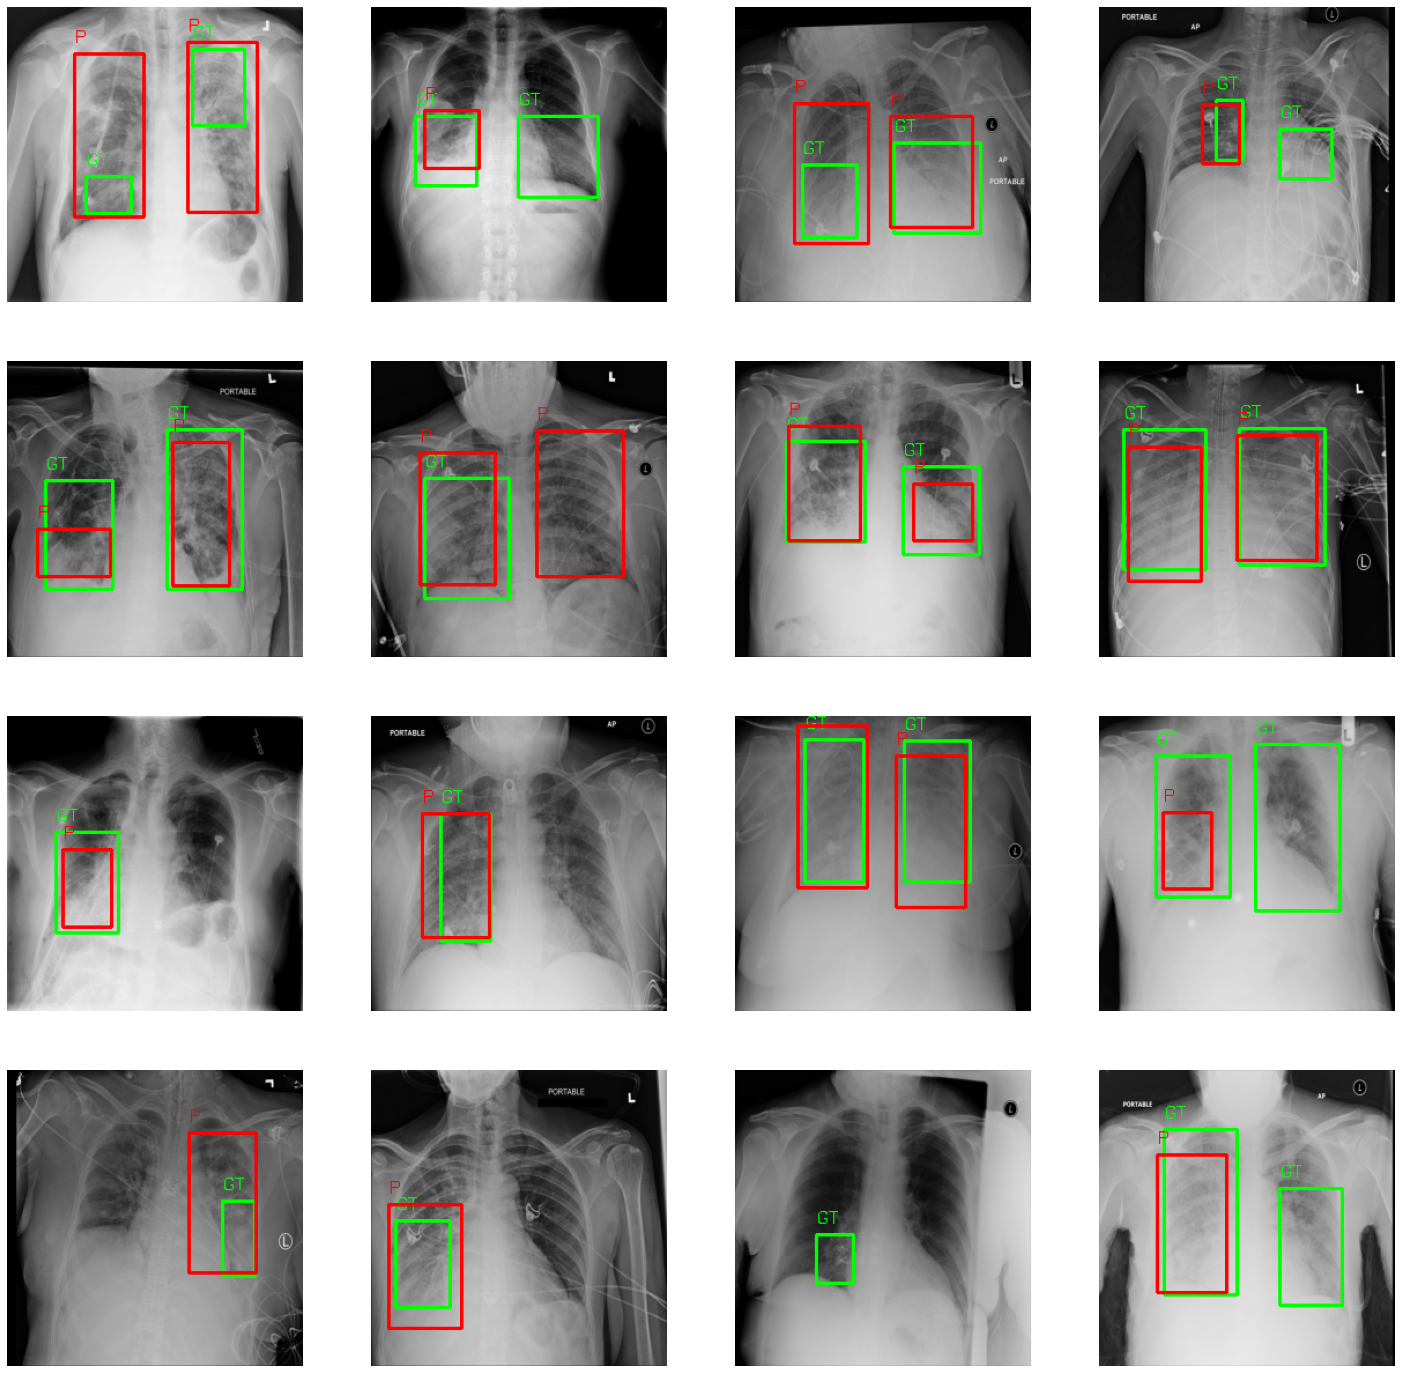

In [86]:
show_result(csv_path,patient_ids_validation,images_path,0.5,0.2 )#,0.5,0.3) 

## **Calculate mAP**

In [67]:
# https://github.com/guigzzz/Keras-Yolo-v2/blob/master/postprocessing.py
import numpy as np
import os
import shutil
import subprocess


def logistic(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_out = np.exp(x - np.max(x, axis=-1)[..., None])
    return exp_out / np.sum(exp_out, axis=-1)[..., None]


# https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
def non_max_suppression(boxes, labels, conf, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        i = idxs[-1]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:-1]])
        yy1 = np.maximum(y1[i], y1[idxs[:-1]])
        xx2 = np.minimum(x2[i], x2[idxs[:-1]])
        yy2 = np.minimum(y2[i], y2[idxs[:-1]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:-1]]

        # delete all indexes from the index list that have
        idxs = (idxs[:-1])[overlap < overlapThresh]

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick], labels[pick], conf[pick]


def getBoundingBoxesFromNetOutput(clf, anchors, confidence_threshold, cell_size, pred=True):
    pw, ph = anchors[:, 0], anchors[:, 1]
    cell_inds = np.arange(clf.shape[1])

    tx = clf[..., 0]
    ty = clf[..., 1]
    tw = clf[..., 2]
    th = clf[..., 3]
    to = clf[..., 4]

    sftmx = softmax(clf[..., 5:])
    predicted_labels = np.argmax(sftmx, axis=-1)
    class_confidences = np.max(sftmx, axis=-1)

    if pred:
        bx = logistic(tx) + cell_inds[None, :, None]
        by = logistic(ty) + cell_inds[:, None, None]
        bw = pw * np.exp(tw) / 2
        bh = ph * np.exp(th) / 2
        object_confidences = logistic(to)
    else:
        bx = tx  # logistic(tx) + cell_inds[None, :, None]
        by = ty  # logistic(ty) + cell_inds[:, None, None]
        bw = tw / 2  # pw * np.exp(tw) / 2
        bh = th / 2  # ph * np.exp(th) / 2
        object_confidences = to

    left = bx - bw
    right = bx + bw
    top = by - bh
    bottom = by + bh

    boxes = np.stack((
        left, top, right, bottom
    ), axis=-1) * cell_size

    final_confidence = class_confidences * object_confidences
    boxes = boxes[final_confidence > confidence_threshold].reshape(-1, 4).astype(np.int32)
    labels = predicted_labels[final_confidence > confidence_threshold]
    return boxes, labels, final_confidence[final_confidence > confidence_threshold]


def yoloPostProcess(yolo_output, priors, maxsuppression=True, maxsuppressionthresh=0.5, classthresh=0.6, cell_size=32,
                    pred=True):
    allboxes = []
    for o in yolo_output:
        boxes, labels, conf = getBoundingBoxesFromNetOutput(o, priors, confidence_threshold=classthresh,
                                                            cell_size=cell_size, pred=pred)
        if maxsuppression and len(boxes) > 0:
            boxes, labels, conf = non_max_suppression(boxes, labels, conf, maxsuppressionthresh)
        allboxes.append((boxes, labels, conf))
    return allboxes


def evaluate_detection(y_true, y_pred, anchor_boxes, classthresh=0.1, GT_path='mAP/input/ground-truth/',
                       pred_path='mAP/input/detection-results/'):
    # refrence https://github.com/Cartucho/mAP
    if not os.path.isdir('mAp'):
        os.system("git clone https://github.com/Cartucho/mAP.git")

    if os.path.isdir(GT_path):
        shutil.rmtree(GT_path)
    os.mkdir(GT_path)

    if os.path.isdir(pred_path):
        shutil.rmtree(pred_path)
    os.mkdir(pred_path)

    boxes_gt = yoloPostProcess(y_true, anchor_boxes, pred=False)
    boxes_pred = yoloPostProcess(y_pred, anchor_boxes, pred=True, classthresh=classthresh)

    for index, (gt, pred) in enumerate(zip(boxes_gt, boxes_pred)):
        gt_str = ""
        for (box, label, conf) in zip(gt[0], gt[1], gt[2]):
            gt_str += "Pneumonia " + str(box[0]) + " " + str(box[1]) + " " + str(box[2]) + " " + str(box[3]) + "\n"

        open(os.path.join(GT_path, str(index) + ".txt"), 'w').write(gt_str)

        pred_str = ""
        for (box, label, conf) in zip(pred[0], pred[1], pred[2]):
            pred_str += "Pneumonia " + str(conf) + " " + str(box[0]) + " " + str(box[1]) + " " + str(
                box[2]) + " " + str(box[3]) + "\n"

        open(os.path.join(pred_path, str(index) + ".txt"), 'w').write(pred_str)

    mAP_str = subprocess.check_output("cd mAP/;python3 main.py --no-plot -na", shell=True);
    mAP = str(mAP_str).split('mAP')[1].split('%')[0].split(' ')[-1]

    return float(mAP) / 100

In [68]:
def get_predictions_GT_single_head(predictions ,Y, Ground_truth_dict ,predictions_dict,model_type='detector'):
    output_name=""
    if model_type == 'detector':
        model_type= "detection"

        
    if np.isnan(Ground_truth_dict[model_type]).all():
        Ground_truth_dict[model_type]= Y
    else:
        Ground_truth_dict[model_type ]= np.append(Ground_truth_dict[model_type] ,Y ,axis=0)

    if np.isnan(predictions_dict[model_type]).all():
        predictions_dict[model_type ]= predictions
    else:
        predictions_dict[model_type ]= np.append(predictions_dict[model_type] ,predictions ,axis=0)
        
    return Ground_truth_dict,predictions_dict

In [69]:
def evaluate(val_gen,model , model_type="detector" , anchors=ANCHORS):
    
    """
    val_gen: keras data generator.
        This is the validation set data generator
    model: keras model
        is the keras model you want to evaluate
    model_type: string
        This string describes the model you passed.It can be one of the following
        'MTL': The full MTL model
        'detector': Encoder+detector head
        'segmenter': Encoder+segmenter head
        'classifier': Encoder+classifier head
    
    anchors: numpy array
        provided only if the model type is 'MTL' or 'detector'
        This is the detection anchor boxes used in training.
    """
    val_gen_itterator = val_gen.__iter__()

    Ground_truth_dict = {
        # "classification": np.nan,
        "detection": np.nan,
        # "segmentation": np.nan
    }

    predictions_dict = {
        # "classification": np.nan,
        "detection": np.nan,
        # "segmentation": np.nan
    }

    for index, (X, Y) in enumerate(val_gen_itterator):
        predictions = model.predict(X)
        Ground_truth_dict, predictions_dict = get_predictions_GT_single_head(predictions, Y, Ground_truth_dict, predictions_dict,model_type)
      
    mAP = evaluate_detection(Ground_truth_dict["detection"], predictions_dict['detection'],anchors)
    return mAP
    
    

In [84]:
model2 = tf.keras.models.load_model("/content/DetectionModel.h5", custom_objects={'loss':loss})

In [87]:
v=evaluate(validation_generator,model2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


In [88]:
v #0.3818 0.35 model,0.40 d1,0.27 d2,0.38 d3 ,0.34 d4

0.39630000000000004